In [1]:
!pip install openpyxl
!pip install xlsxwriter

In [2]:
import pandas as pd
import numpy as np
import openpyxl
import xlsxwriter

import statsmodels.api as sm
from scipy.stats import ttest_rel, t
from scipy.stats import shapiro, anderson, wilcoxon
from scipy.stats import ttest_rel, false_discovery_control

from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin


In [4]:
# Set the random seed for reproducibility
np.random.seed(42)

In [5]:
!unzip "/content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip"


Archive:  /content/drive/MyDrive/Colab_Notebooks/oai/control_used_for_embedding/Noto_Serif.zip
replace OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: NotoSerif-Regular.ttf   
replace NotoSerif-Italic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-Bold.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace NotoSerif-BoldItalic.ttf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
!mv NotoSerif-Regular.ttf /usr/share/fonts/truetype/

**Merge Dataframes**

In [7]:
def load_and_merge_data(full_data_path, match_data_path, merge_key, selected_columns):
    full_df = pd.read_csv(full_data_path)
    match_df = pd.read_csv(match_data_path, usecols=selected_columns)
    merged_df = pd.merge(match_df, full_df, on=merge_key, how='left')
    return merged_df

selected_columns = ['distance','id']
oa_inc_matched_df = load_and_merge_data(
    'publish_dataframes/oa_inc_multiple_imputation_filled.csv',
    'publish_dataframes/rand_state_oa_inc_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)
# oa_inc_matched_df

tkr_matched_df = load_and_merge_data(
    'publish_dataframes/tkr_multiple_imputation_filled.csv',
    'publish_dataframes/rand_state_tkr_matchit_TSNE_EuclideanDist_Replacement_df.csv',
    'id',
    selected_columns
)


box-plots

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_boxplot(df, target_column, columns_to_plot, path_to_font, title, control_color, treatment_color, treatment_label, save_path=None):
    # Font properties
    fontprop = fm.FontProperties(fname=path_to_font, size=15)

    # Map numeric values to 'Control' and the specified treatment label
    df_mapped = df.copy()
    df_mapped[target_column] = df[target_column].map({0: 'Control', 1: treatment_label})

    # Melt the data
    melted_data = pd.melt(df_mapped, id_vars=target_column, value_vars=columns_to_plot)

    # Ensure the 'Control' group is always plotted on the left
    melted_data[target_column] = pd.Categorical(melted_data[target_column], categories=['Control', treatment_label], ordered=True)
    melted_data['variable'] = pd.Categorical(melted_data['variable'], categories=columns_to_plot, ordered=True)
    melted_data.sort_values(by=[target_column, 'variable'], inplace=True)

    # Create a boxplot
    # plt.figure(figsize=(12, 8))
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    sns.boxplot(x='variable', y='value', hue=target_column, data=melted_data, palette=[control_color, treatment_color])
    plt.title(title, fontsize=20, pad=20, fontproperties=fontprop)
    plt.xlabel('Significant PC Mode', fontproperties=fontprop)
    plt.ylabel('PC Value', fontproperties=fontprop)

    # Adjust ylim and xticks
    current_ylim = plt.ylim()  # get current limits
    new_ylim = (current_ylim[0], current_ylim[1] * 1.2)  # increasing the upper limit by 20%
    plt.ylim(new_ylim)
    plt.xticks(rotation=45)

    # Adjust the legend
    plt.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)
    plt.setp(ax.get_legend().get_texts(), fontproperties=fontprop) # legend text
    plt.setp(ax.get_legend().get_title(), fontproperties=fontprop)

    # Tick labels font settings
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(fontprop)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.75, 0.95])

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        plt.show()


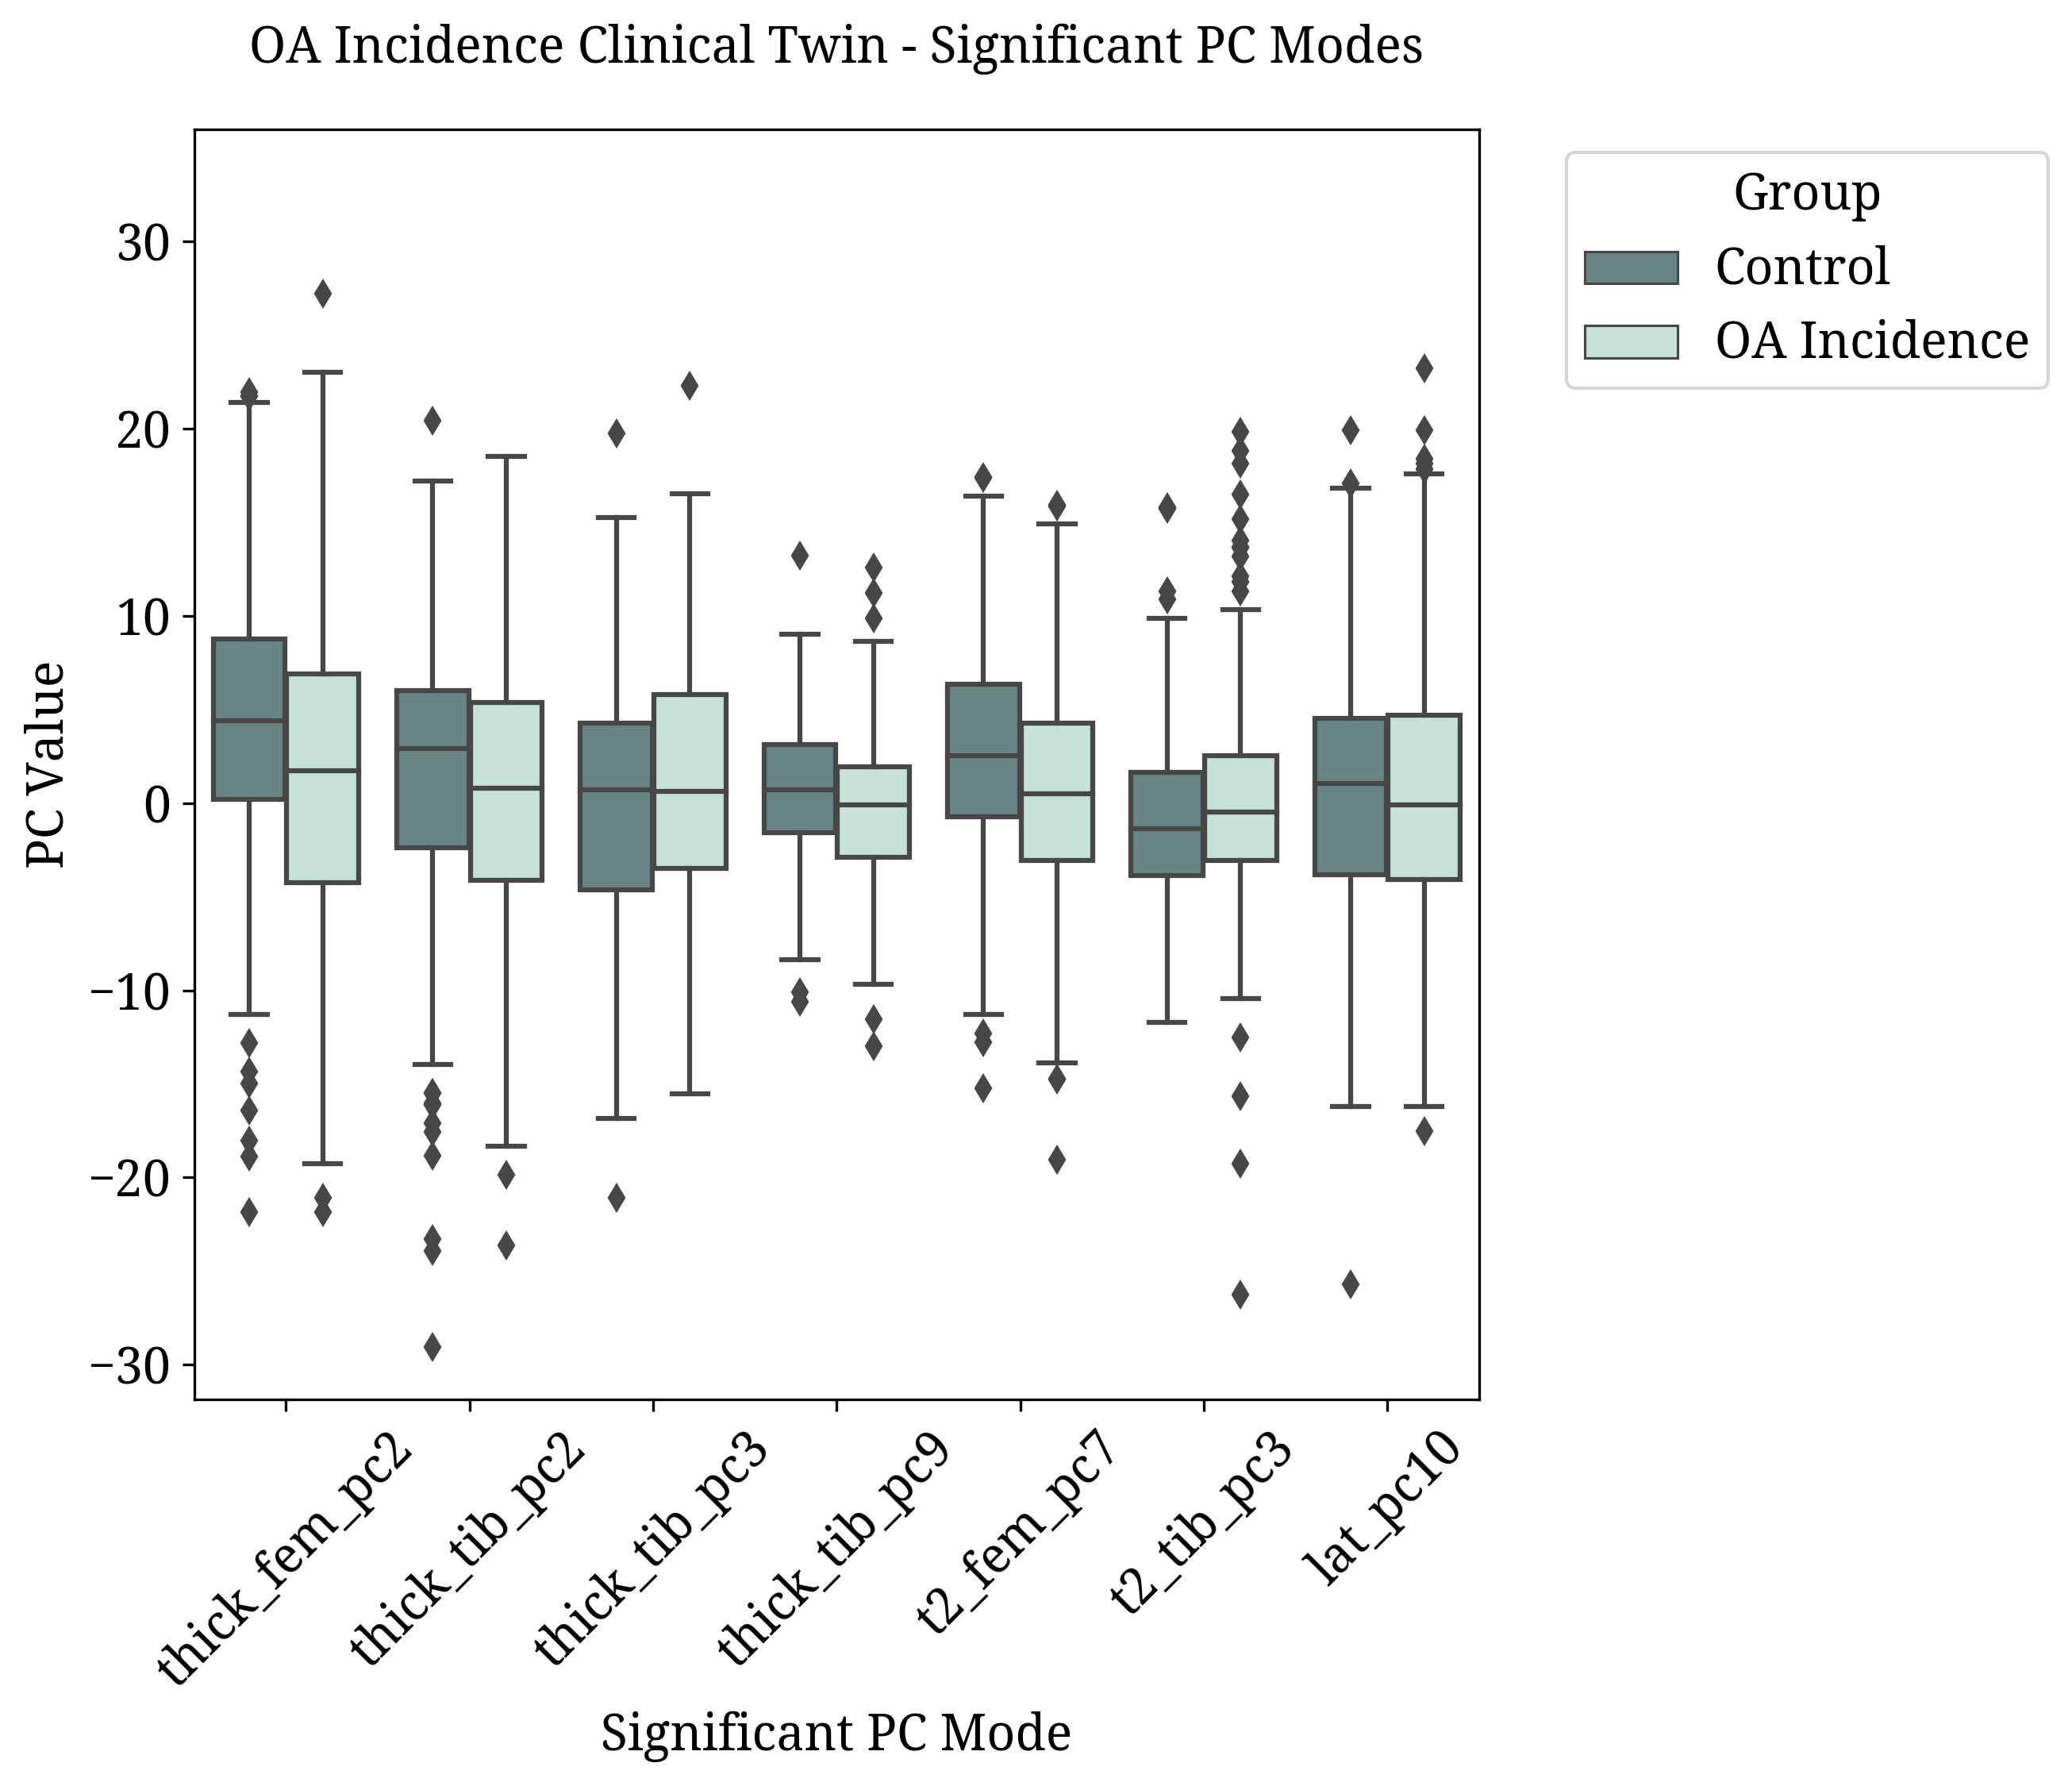

In [ ]:

# columns = oa_inc_matched_df.iloc[:,-110:-105]

columns = ['thick_fem_pc2', 'thick_tib_pc2', 'thick_tib_pc3', 'thick_tib_pc9',
        't2_fem_pc7', 't2_tib_pc3',
        'lat_pc10']

cmap = sns.cubehelix_palette(start=.5, rot=-.5)
treatment_color = cmap[0]
control_color='#64888A'

# Example usage
create_boxplot(oa_inc_matched_df,
               target_column='oa_prog',
               columns_to_plot=columns,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="OA Incidence Clinical Twin - Significant PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'OA Incidence')

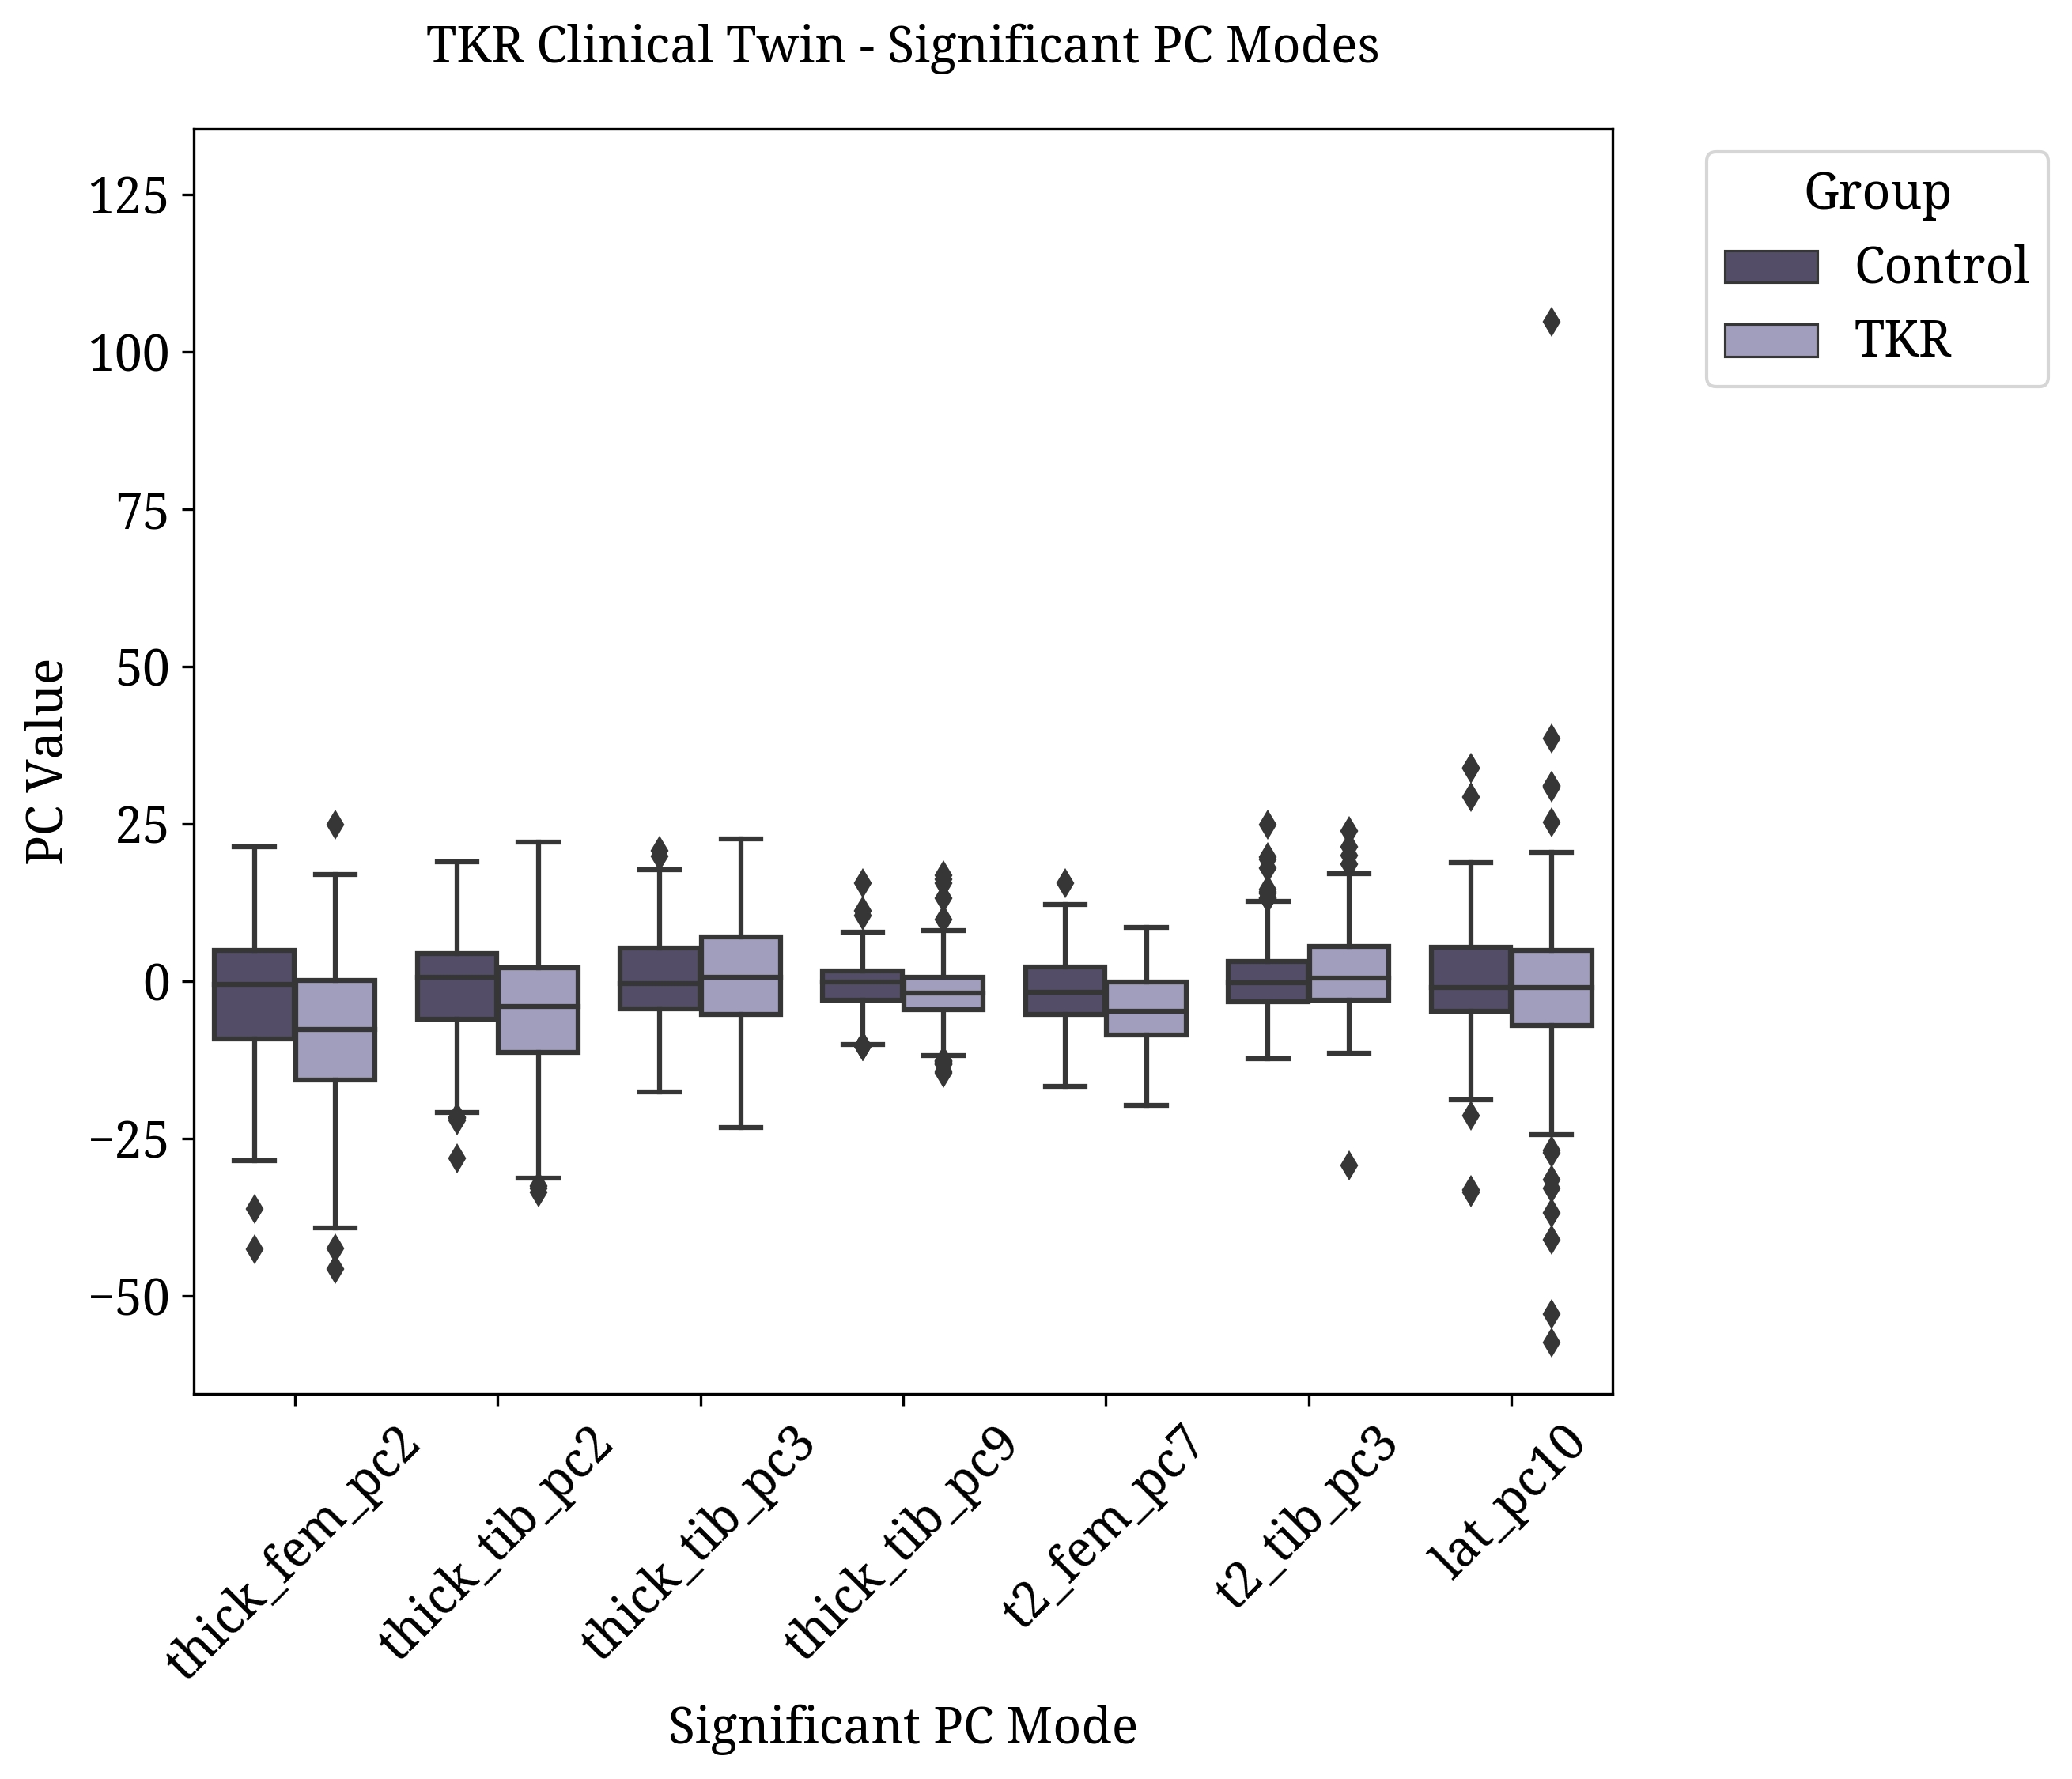

In [ ]:

# columns = oa_inc_matched_df.iloc[:,-110:-105]

columns = ['thick_fem_pc2', 'thick_tib_pc2', 'thick_tib_pc3', 'thick_tib_pc9',
        't2_fem_pc7', 't2_tib_pc3',
        'lat_pc10']

treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

# Example usage
create_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=columns,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR')

# **Advanced Box-plot with significant p-value**

**get wilcoxon statistic again - p-value**

In [11]:

def bootstrap_median_difference(treatment_col, control_col, n_bootstrap=1000, confidence_levels=[95, 99], seed=None):
    """
    Performs bootstrap analysis to estimate confidence intervals of the median differences between two columns.

    Parameters:
    treatment_col (array-like): The treatment group column.
    control_col (array-like): The control group column.
    n_bootstrap (int): The number of bootstrap samples to draw.
    confidence_levels (list): The confidence levels for which to compute the intervals.
    seed (int, optional): The seed for the random number generator.

    Returns:
    dict: Confidence intervals for each specified level.
    """
    if seed is not None:
        np.random.seed(seed)

    if len(treatment_col) != len(control_col):
        raise ValueError("Treatment and control columns must be of the same length.")

    bootstrapped_medians = []
    for _ in range(n_bootstrap):
        resampled_oa = np.random.choice(treatment_col, size=len(treatment_col), replace=True)
        resampled_control = np.random.choice(control_col, size=len(control_col), replace=True)
        median_diff = np.median(resampled_oa - resampled_control)
        bootstrapped_medians.append(median_diff)

    ci_bounds = {}
    for level in confidence_levels:
        if not (0 < level < 100):
            raise ValueError("Confidence levels must be between 0 and 100.")
        lower_bound = np.percentile(bootstrapped_medians, (100 - level) / 2)
        upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - level) / 2)
        ci_bounds[level] = (lower_bound, upper_bound)

    return ci_bounds


In [8]:

def perform_statistical_tests(dataframe, group_column, variable_columns_range, non_norm_columns):
    # Extracting groups
    group_control = dataframe[dataframe[group_column] == 0].reset_index(drop=True)
    group_treatment = dataframe[dataframe[group_column] == 1].reset_index(drop=True)

    # Ensure equal sizes
    assert len(group_control) == len(group_treatment), "Groups are not paired correctly!"

    # Define named tuples for results
    TestResults = namedtuple('TestResults', ['column', 't_stat', 'p_value', 'adj_p_value', 'df', 'ci_95_low', 'ci_95_high', 'ci_99_low', 'ci_99_high', 'test_type', 'mean_diff', 'margin_of_err95', 'margin_of_err99', 'point_estimate_ci_95', 'point_estimate_ci_99'])
    WilcoxonTestResults = namedtuple('WilcoxonTestResults', ['column', 'wilcoxon_stat', 'p_value', 'adj_p_value', 'df', 'ci_95_low', 'ci_95_high', 'ci_99_low', 'ci_99_high', 'test_type', 'median_diff', 'margin_of_err95', 'margin_of_err99', 'point_estimate_ci_95', 'point_estimate_ci_99'])

    results = []
    numerical_p_values = []

    # Loop through variable columns
    for col in dataframe.iloc[:, variable_columns_range:].columns:
        control_col = group_control[col].dropna()
        treatment_col = group_treatment[col].dropna()

        # Ensure equal sizes
        if len(control_col) != len(treatment_col):
            print(f"Column: {col} - Groups are not paired correctly or have missing data!")
            continue

        # Determine if we should use t-test or Wilcoxon test
        if col in non_norm_columns:

            # Calculate the median difference / point estimate for Wilcoxon test
            median_diff = np.median(treatment_col - control_col)

            # Perform Wilcoxon Signed-Rank Test instead of t-test
            stat, p_value = wilcoxon(treatment_col, control_col)
            # No direct method for confidence intervals in Wilcoxon test, consider using a bootstrapping method if needed

            # Perform bootstrapping for confidence intervals
            ci_bounds = bootstrap_median_difference(treatment_col, control_col, n_bootstrap=1000, confidence_levels=[95, 99])

            # Use the number of non-missing paired observations minus one for df
            df = len(control_col) - 1

            # Accumulate p-values for Wilcoxon tests
            numerical_p_values.append(p_value)

            # margin of error calculation:
            margin_of_err95 = (ci_bounds[95][1] - ci_bounds[95][0]) / 2
            margin_of_err99 = (ci_bounds[99][1] - ci_bounds[99][0]) / 2

            # point estimate [CI lower, CI upper]:
            formatted_ci_95 = f"{median_diff}, 95% CI: [{ci_bounds[95][0]}, {ci_bounds[95][1]}]"
            formatted_ci_99 = f"{median_diff}, 99% CI: [{ci_bounds[99][0]}, {ci_bounds[99][1]}]"

            # Append results with bootstrapped confidence intervals
            results.append(WilcoxonTestResults(col, stat, p_value, None, df,
                                                        ci_bounds[95][0], ci_bounds[95][1],
                                                        ci_bounds[99][0], ci_bounds[99][1],
                                                        'wilcoxon', median_diff, margin_of_err95, margin_of_err99,
                                                        formatted_ci_95, formatted_ci_99
                                              ))

        else:
            # Calculate the mean difference / point estimate for t-test
            mean_diff = np.mean(treatment_col - control_col)

            # Paired t-test
            l = ttest_rel(treatment_col, control_col)

            df = len(control_col) - 1

            try:
                ci_95 = l.confidence_interval(confidence_level=0.95)
                ci_99 = l.confidence_interval(confidence_level=0.99)
            except AttributeError:
                print(f"Column: {col} - 'confidence_interval' method is not available. Update SciPy or use an alternative method.")
                continue

            # Accumulate p-values for numerical tests
            numerical_p_values.append(l.pvalue)

                    # margin of error calculation:
            margin_of_err95 = (ci_95.high - ci_95.low) / 2
            margin_of_err99 = (ci_99.high - ci_99.low) / 2

            # point estimate [CI lower, CI upper]:
            formatted_ci_95 = f"{mean_diff}, 95% CI: [{ci_95.low}, {ci_95.high}]"
            formatted_ci_99 = f"{mean_diff}, 99% CI: [{ci_99.low}, {ci_99.high}]"


            # Append results with None for adj_p_value
            results.append(TestResults(col, l.statistic, l.pvalue, None, df, ci_95.low, ci_95.high, ci_99.low, ci_99.high, 'ttest', mean_diff, margin_of_err95, margin_of_err99,
                                      formatted_ci_95, formatted_ci_99
                                      ))

    # Accumulate all p-values from both numerical and categorical tests
    all_p_values = numerical_p_values

    # Apply Hochberg correction to the combined p-values
    adj_all_p_values = false_discovery_control(all_p_values, method='bh')

    # Separate the adjusted p-values back into numerical and categorical
    adj_numerical_p_values = adj_all_p_values[:len(numerical_p_values)]

    # Assign the adjusted p-values back to the results
    for i in range(len(results)):
        results[i] = results[i]._replace(adj_p_value=adj_numerical_p_values[i])

    # Convert results into a DataFrame
    results_df = pd.DataFrame(results)

    return results_df



**box-plot with sig value**

In [9]:
def get_significant_variables_with_p_values(stats_df):
    """
    Extracts variables and their adjusted p-values if they are significant (p < 0.05)
    from the provided statistics dataframe.

    :param stats_df: DataFrame containing statistical test results, including 'column' and 'adj_p_value'.
    :return: DataFrame with 'column' and 'adj_p_value' for significant results.
    """
    # Filter for significant adjusted p-values
    significant_results = stats_df[stats_df['adj_p_value'] < 0.05][['column', 'adj_p_value']]

    return significant_results

In [13]:
def add_significance_bar(ax, x_left, x_right, y, y_extend, text, fontprop):
    """
    Adds a custom significance bar that extends over both the Control and Treatment boxes.

    :param ax: The axis object to draw the bar on.
    :param x_left: The x coordinate of the left side of the bar.
    :param x_right: The x coordinate of the right side of the bar.
    :param y: The y coordinate of the top of the bar.
    :param y_extend: The length of the downward extension on both sides.
    :param text: The text to display above the bar.
    :param fontprop: Font properties for the text.
    """
    # Draw the main horizontal line
    ax.plot([x_left, x_right], [y, y], color='black', lw=1.5)
    # Draw the downward extension on both sides
    ax.plot([x_left, x_left], [y, y - y_extend], color='black', lw=1.5)
    ax.plot([x_right, x_right], [y, y - y_extend], color='black', lw=1.5)

    # Add the text above the bar
    ax.text((x_left + x_right) / 2, y + y_extend * 0.1, text, ha='center', va='bottom', color='black', fontsize=12, fontproperties=fontprop)


In [54]:
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D

def create_annotated_boxplot(df, target_column, columns_to_plot, path_to_font, title, control_color, treatment_color, treatment_label, p_values_df, save_path=None):
    # Font properties
    fontprop = fm.FontProperties(fname=path_to_font, size=15)

    num_cols = 3  # Adjust based on preference
    num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*4, num_rows*7), dpi=300)
    axes = axes.flatten()

    # Loop through the variables and create a boxplot for each
    for i, col_name in enumerate(columns_to_plot):
        ax = axes[i]
        # sns.boxplot(x='variable', y='value', hue=target_column, data=melted_data, palette=[control_color, treatment_color])
        sns.boxplot(x=target_column, y=col_name, data=df, palette=[control_color, treatment_color], ax=ax)
        ax.set_title(col_name, fontproperties=fontprop, pad=20)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Increase the y-axis limit by 20% to accommodate the significance bar
        current_ylim = ax.get_ylim()
        new_ylim = (current_ylim[0], current_ylim[1] * 1.35)
        ax.set_ylim(new_ylim)

        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(fontprop)

        # Find the p-value for the current variable and add the significance bar
        if col_name in p_values_df['column'].values:
            row = p_values_df[p_values_df['column'] == col_name].iloc[0]
            p_value = row['adj_p_value']

            y_height = df[col_name].max() + (df[col_name].max() - df[col_name].min()) * 0.1

            display_text = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'

            # You can adjust the offset (0.2) to control how much the bar extends beyond the boxes
            add_significance_bar(ax,  0,  1, y_height, 0.05*y_height, f'p = {p_value:.1e}\n{display_text}', fontprop)

    # Hide any unused subplots
    for j in range(i+1, num_rows*num_cols):
        fig.delaxes(axes[j])

    # Create custom legend handles
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Control',
              markerfacecolor=control_color, markersize=15),
        Line2D([0], [0], marker='s', color='w', label=treatment_label,
              markerfacecolor=treatment_color, markersize=15),
    ]

    # Add the legend to the current axes
    legend = fig.legend(handles=legend_elements, loc='upper right')

    # Now that the legend is created, set the font properties
    plt.setp(legend.get_texts(), fontproperties=fontprop)  # Set legend text properties
    plt.setp(legend.get_title(), fontproperties=fontprop)  # Set legend title properties

    # Increase the top margin in plt.subplots_adjust
    plt.subplots_adjust(top=1.05)  # You can adjust the value as needed

    # Set the overall title and adjust the layout
    plt.suptitle(title, fontsize=20, fontproperties=fontprop, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.75, 0.95])

        # Save or show the plot
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        plt.show()


**OA Incidence Box plots**

In [32]:
# Example usage for oa_inc_matched_df
non_norm_columns_oa_inc = oa_inc_matched_df.iloc[:,-110:].columns.tolist()
results_df_oa_inc = perform_statistical_tests(oa_inc_matched_df, 'oa_prog', -110, non_norm_columns_oa_inc)

significant_vars_df = get_significant_variables_with_p_values(results_df_oa_inc)

# To get a list of just the significant variable names:
significant_vars_list = significant_vars_df['column'].tolist()
# significant_vars_list

In [ ]:
cmap = sns.cubehelix_palette(start=.5, rot=-.5)
treatment_color = cmap[0]
control_color='#64888A'

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/OA_Inc_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(oa_inc_matched_df,
               target_column='oa_prog',
               columns_to_plot=significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="OA Incidence Clinical Twin - Significant PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'OA Incidence',
               p_values_df=significant_vars_df,
               save_path=save_path)

**TKR Box-plots**

In [35]:
# Example usage for tkr_matched_df
non_norm_columns_tkr = tkr_matched_df.iloc[:,-110:].columns.tolist()
results_df_tkr = perform_statistical_tests(tkr_matched_df, 'tkr', -110, non_norm_columns_tkr)

significant_vars_df = get_significant_variables_with_p_values(results_df_tkr)

In [ ]:
significant_vars_list = significant_vars_df['column'].tolist()
# significant_vars_list

In [56]:

treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/TKR_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR',
               p_values_df=significant_vars_df,
                save_path=save_path)



Output hidden; open in https://colab.research.google.com to view.

**split up by PC mode biomarker**

In [57]:
significant_vars_list

['bs_fem_pc1',
 'bs_fem_pc2',
 'bs_fem_pc7',
 'bs_fem_pc10',
 'bs_pat_pc6',
 'bs_pat_pc7',
 'bs_tib_pc7',
 't2_fem_pc1',
 't2_fem_pc5',
 't2_fem_pc7',
 't2_pat_pc1',
 't2_pat_pc2',
 't2_pat_pc5',
 't2_pat_pc9',
 't2_tib_pc1',
 't2_tib_pc7',
 't2_tib_pc10',
 'thick_fem_pc2',
 'thick_fem_pc3',
 'thick_fem_pc4',
 'thick_fem_pc8',
 'thick_pat_pc1',
 'thick_pat_pc4',
 'thick_pat_pc5',
 'thick_pat_pc9',
 'thick_tib_pc1',
 'thick_tib_pc2',
 'thick_tib_pc4',
 'thick_tib_pc8',
 'thick_tib_pc9',
 'med_pc1',
 'med_pc3',
 'med_pc4',
 'med_pc8',
 'med_pc9',
 'lat_pc2',
 'lat_pc5',
 'lat_pc7']

In [58]:
# Substring to filter by
substring = "bs_"

# Create a new list by filtering strings that contain the substring
bone_significant_vars_list = [s for s in significant_vars_list if substring in s]

bone_significant_vars_list

['bs_fem_pc1',
 'bs_fem_pc2',
 'bs_fem_pc7',
 'bs_fem_pc10',
 'bs_pat_pc6',
 'bs_pat_pc7',
 'bs_tib_pc7']

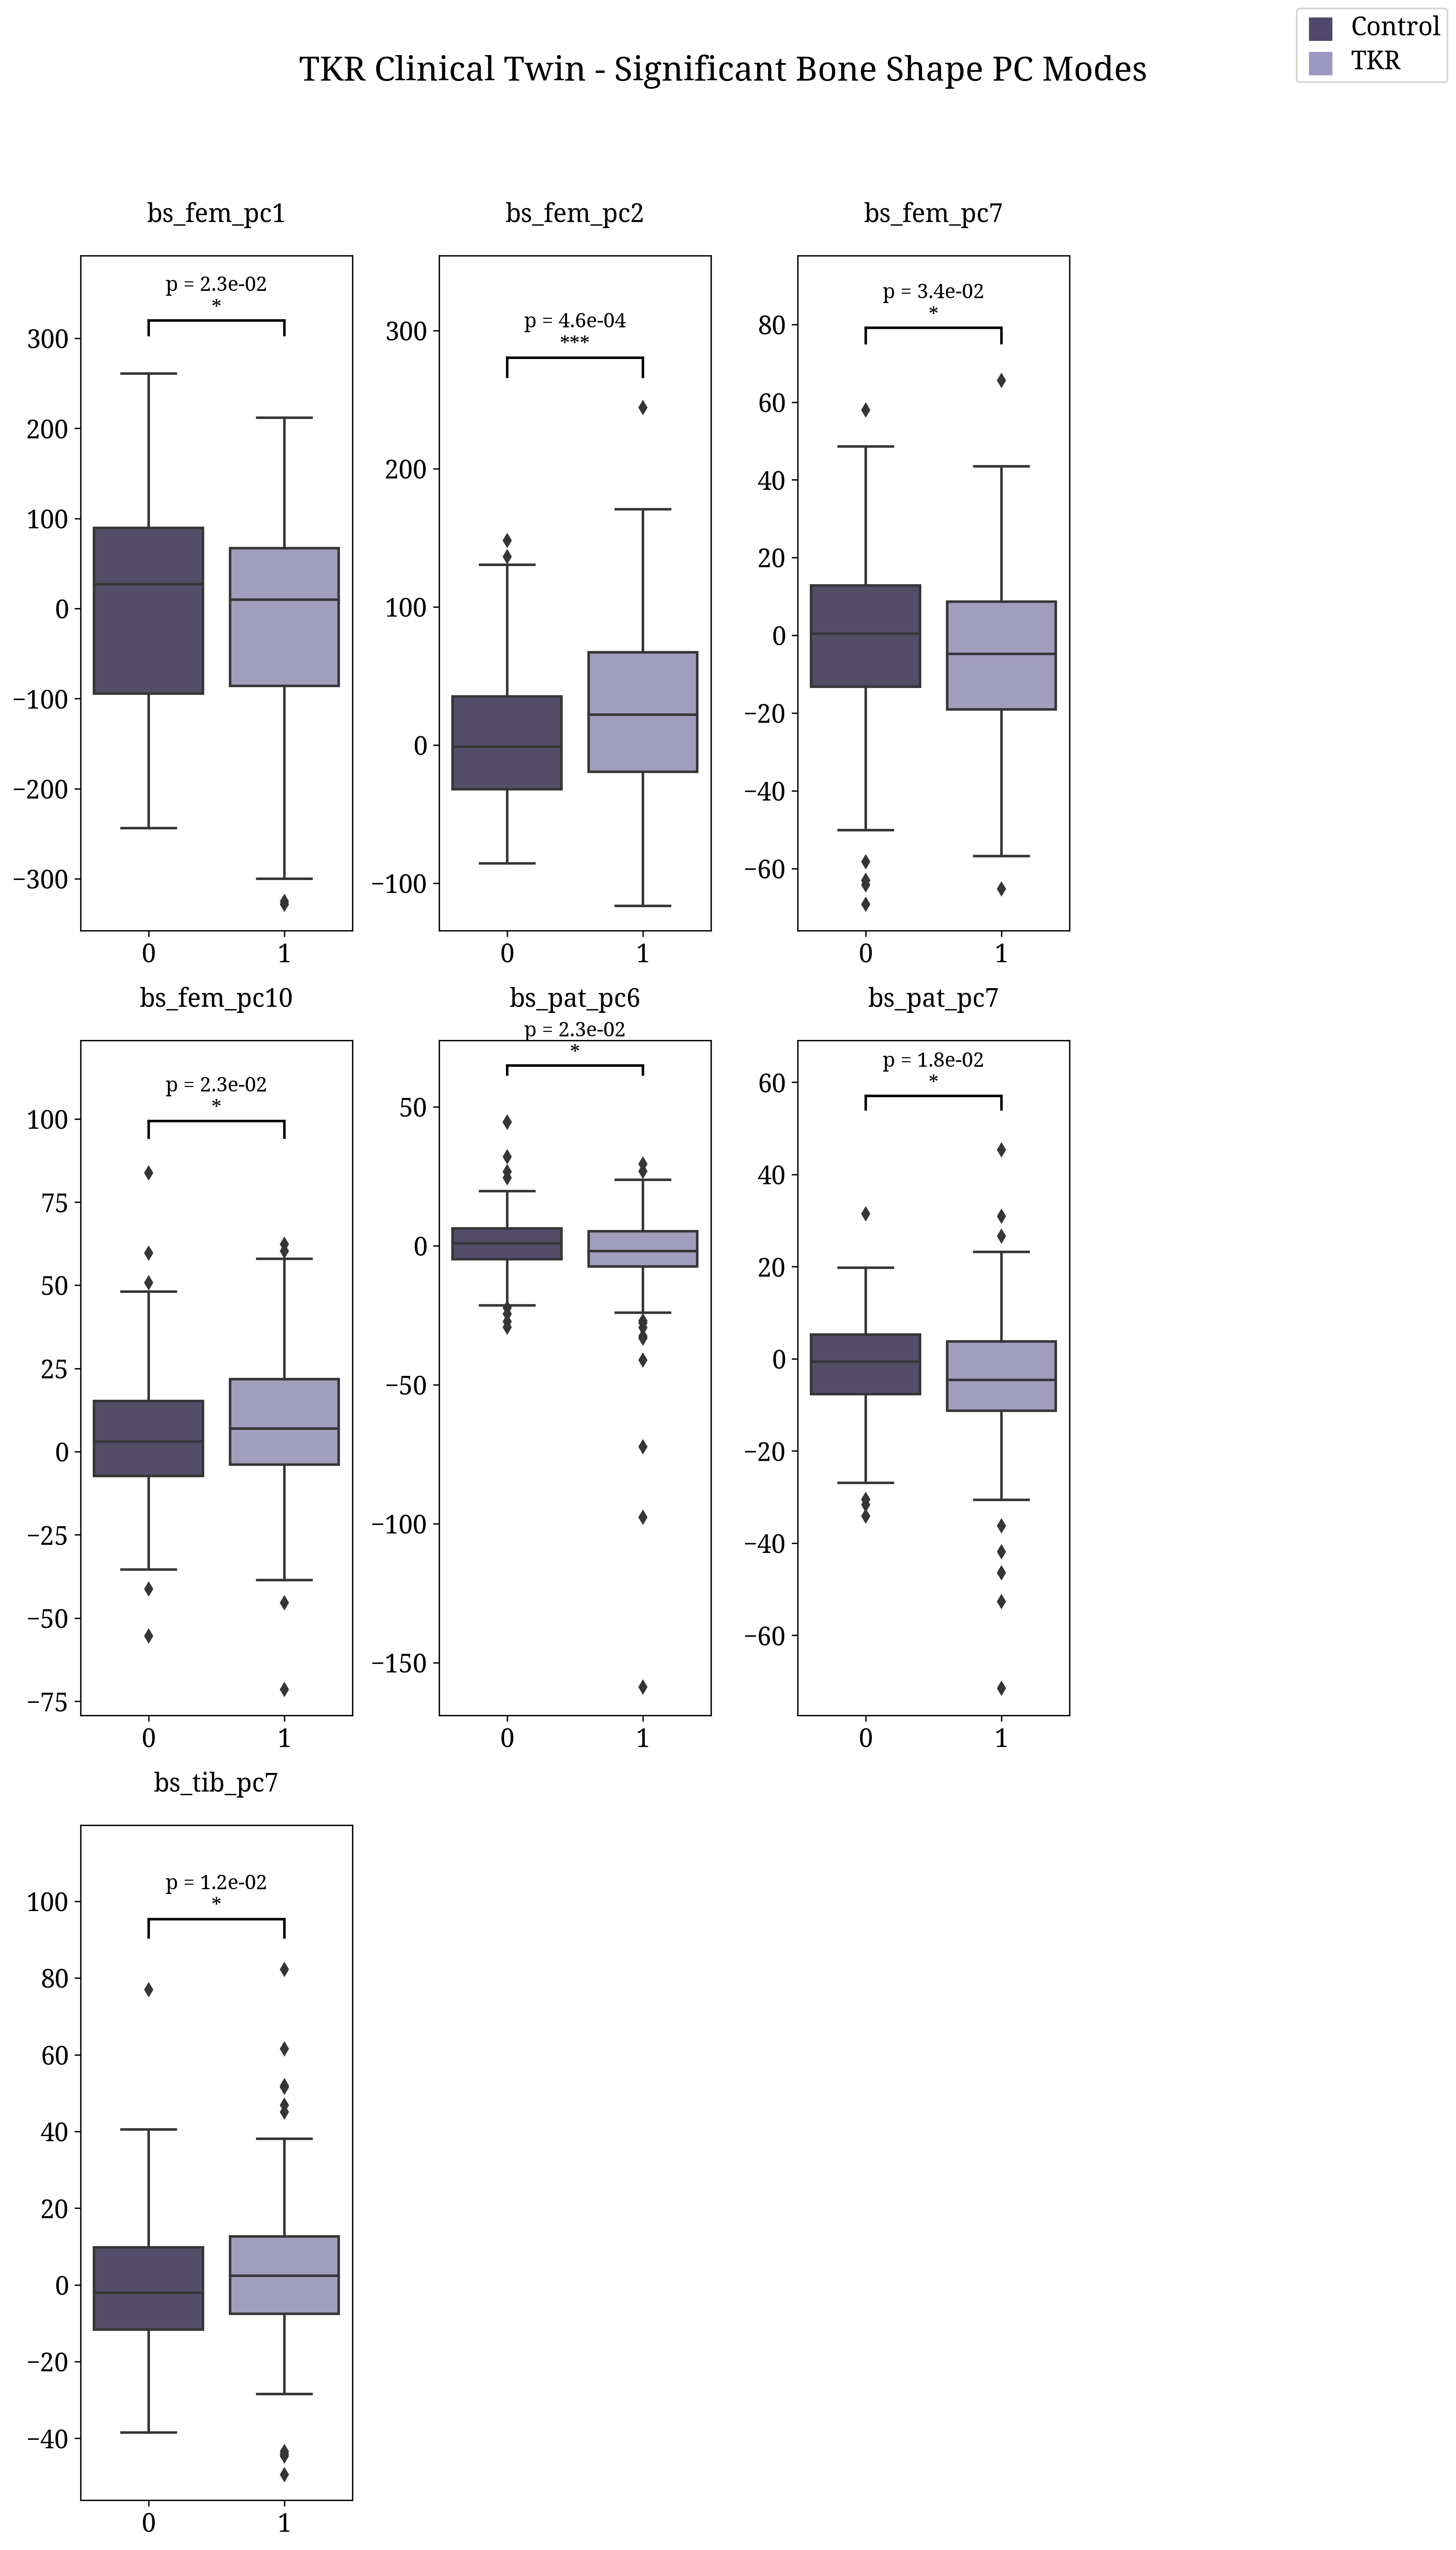

In [59]:


treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/boneShape_TKR_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=bone_significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant Bone Shape PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR',
               p_values_df=significant_vars_df,
                save_path=save_path)



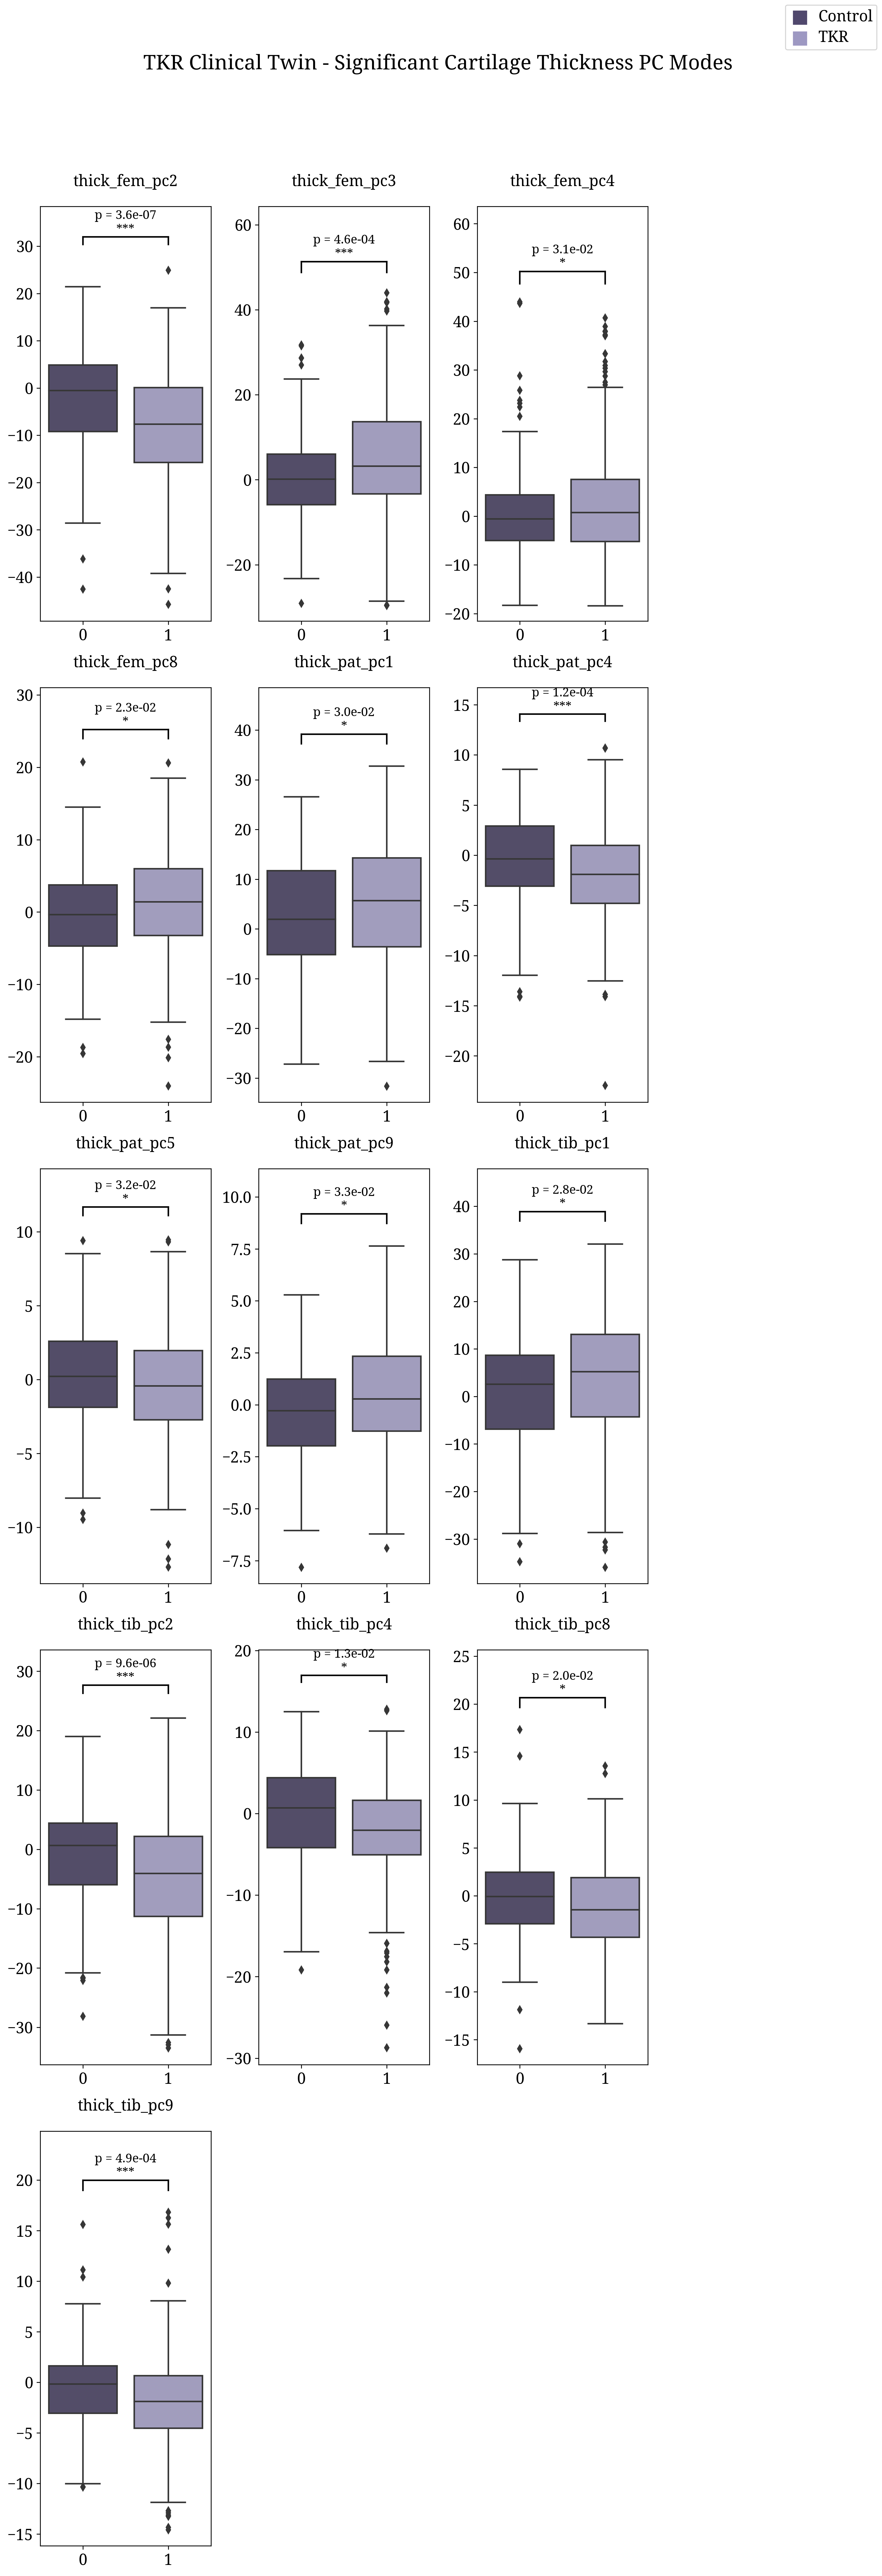

In [61]:
# Substring to filter by
substring = "thick_"

# Create a new list by filtering strings that contain the substring
thick_significant_vars_list = [s for s in significant_vars_list if substring in s]
thick_significant_vars_list



treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/thickness_TKR_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=thick_significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant Cartilage Thickness PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR',
               p_values_df=significant_vars_df,
                save_path=save_path)



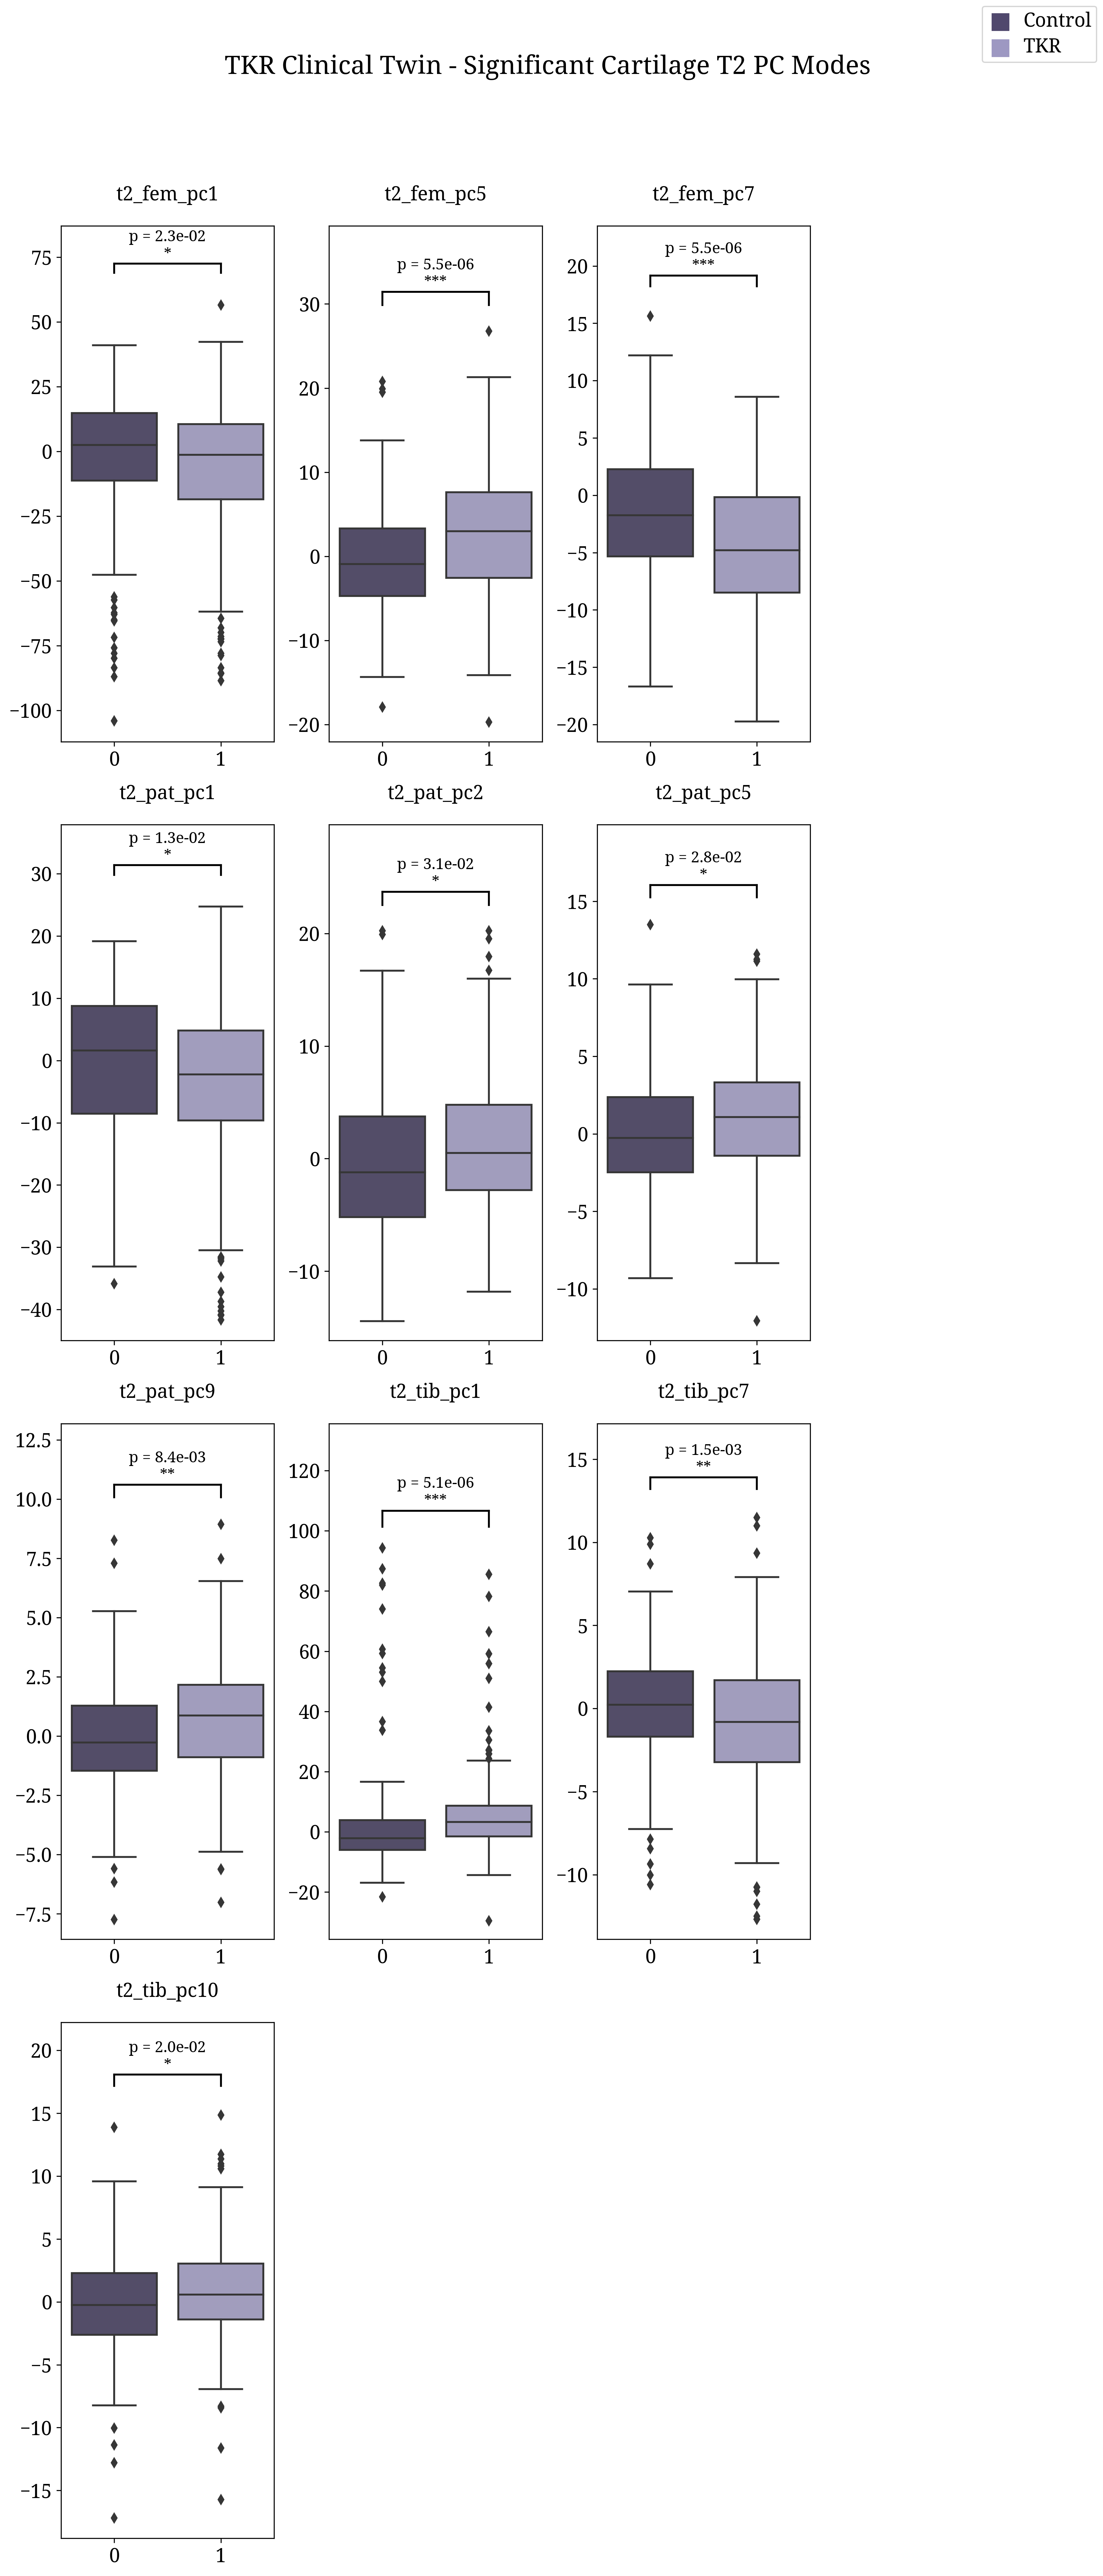

In [62]:
# Substring to filter by
substring = "t2_"

# Create a new list by filtering strings that contain the substring
t2_significant_vars_list = [s for s in significant_vars_list if substring in s]
t2_significant_vars_list


treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/t2_TKR_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=t2_significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant Cartilage T2 PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR',
               p_values_df=significant_vars_df,
                save_path=save_path)



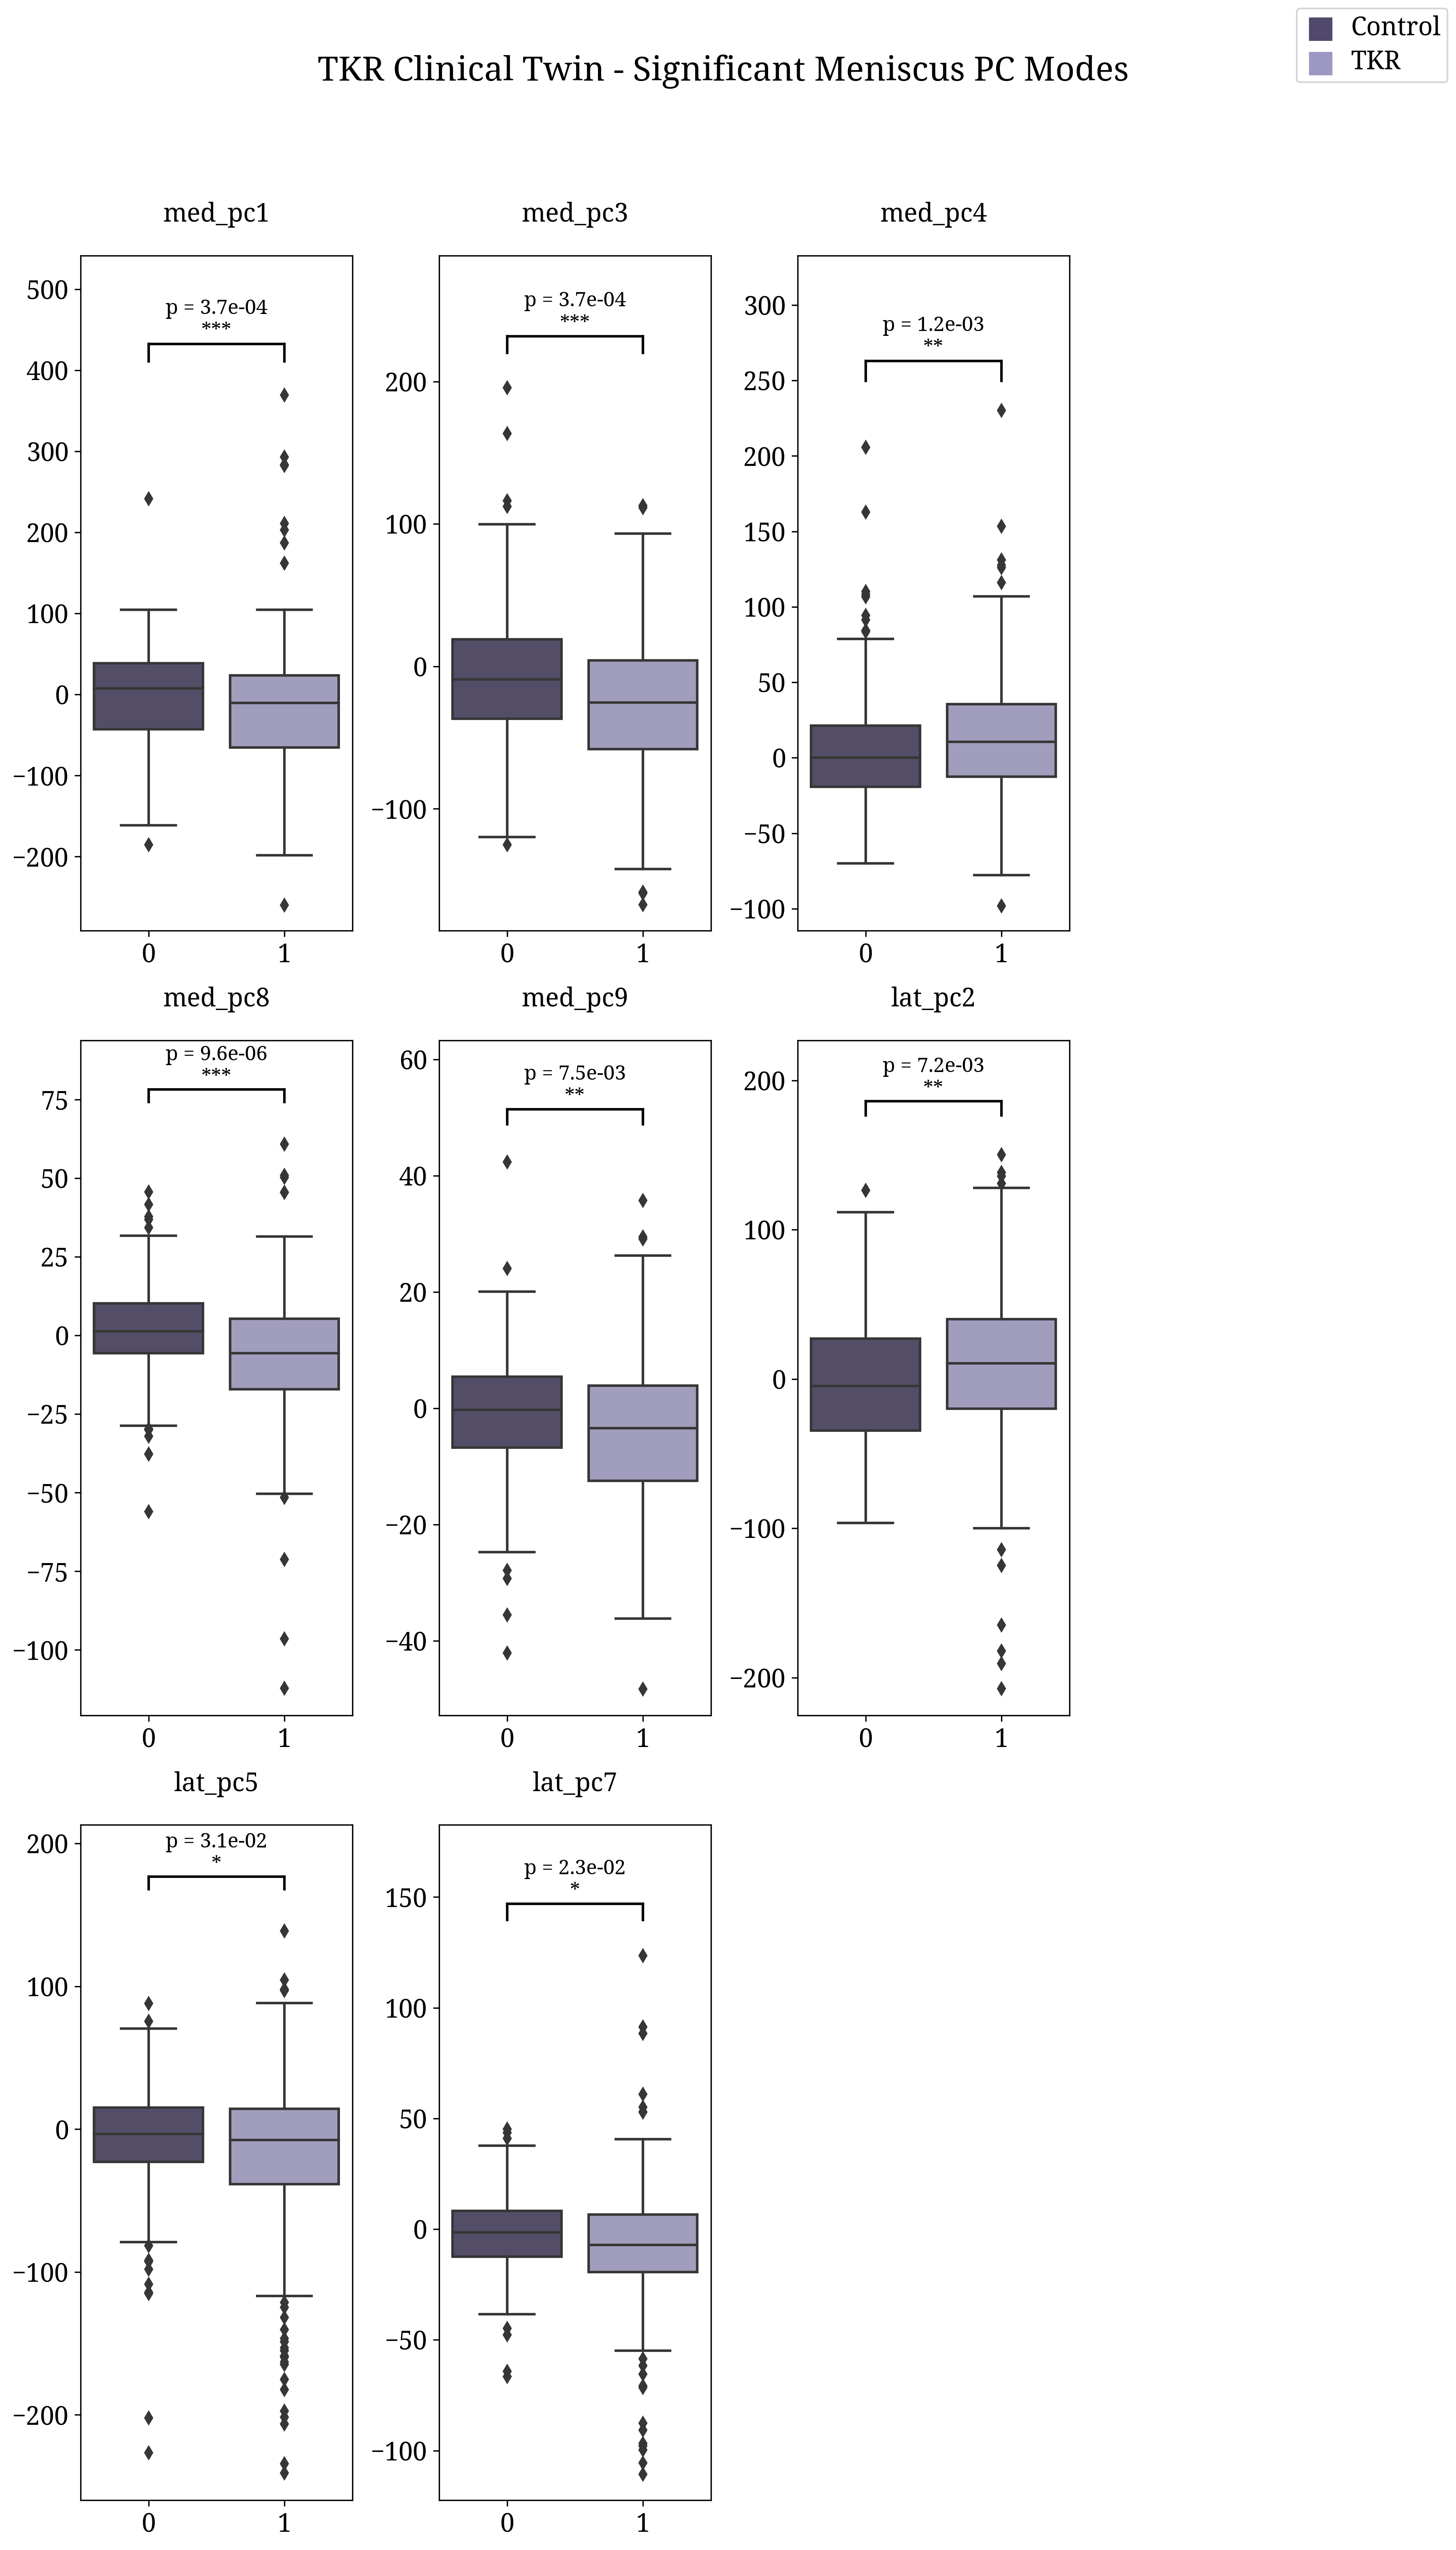

In [64]:
# Substring to filter by
substrings = ["med_", "lat_"]

# Create a new list by filtering strings that contain the substring
men_significant_vars_list = [s for s in significant_vars_list if any(sub in s for sub in substrings)]
men_significant_vars_list


treatment_color = '#9D98C2'
control_color = '#50486D'  # Darker color for control

save_path = '/content/drive/MyDrive/Colab_Notebooks/oai/TKR_twin/publish_dataframes/TSNE_with_random_state/figures/meniscus_TKR_Signif_PC_modes_box_plot.svg'

# Example usage
create_annotated_boxplot(tkr_matched_df,
               target_column='tkr',
               columns_to_plot=men_significant_vars_list,
               path_to_font='/usr/share/fonts/truetype/NotoSerif-Regular.ttf',
               title="TKR Clinical Twin - Significant Meniscus PC Modes",
               control_color=control_color,
               treatment_color=treatment_color,
               treatment_label= 'TKR',
               p_values_df=significant_vars_df,
                save_path=save_path)

